In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import  mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

from utils import *
from gradient import *

import warnings
warnings.filterwarnings("ignore")

Dataset sadrži istorijske podatke o vremenskim uslovima na svakih sat vremena u periodu od 01-01-2020 do 01-01-2024 za Novi Sad. Kako bi se dobili podaci na dnevnom nivou izvršena je grupacija po datumu i izbačene su sve kolone koje nemaju značajne vrednosti za ovu predikciju ili imaju previše nedostajućih vrednosti, neke i do 97%. Podela na trening i validacionu skup je u odnosu 80:20 i kreirani su posebni skupovi za ARIMA i Gradient Boosting modele.

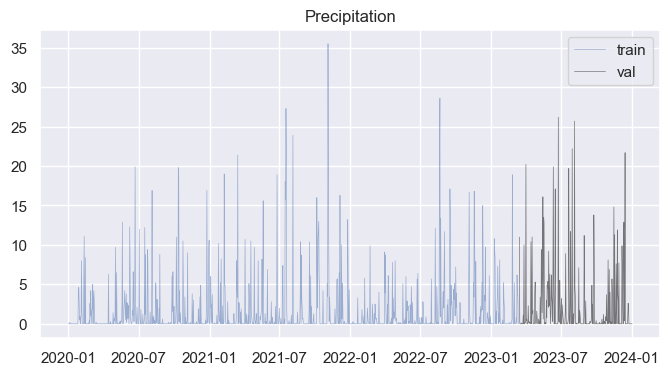

stationary


,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,precipitation,dew_point,temp_min,temp_max
date,,,,,,,,,,
2020-01-01,-0.4,1033.8,90.4,2.4,273.0,539,0.0,-1.8,-4.1,4.9
2020-01-02,-0.5,1034.0,90.3,1.9,213.0,570,0.0,-1.9,-6.7,5.2
2020-01-03,-2.8,1029.0,97.6,2.0,97.6,1133,0.0,-3.1,-4.9,5.7
2020-01-04,-1.1,1024.8,96.7,1.5,237.2,2091,0.0,-1.5,-5.2,6.2
2020-01-05,2.2,1027.2,77.8,5.5,325.3,655,0.2,-1.2,-2.3,7.9


In [2]:
#DATA PREPROCESSING

data = pd.read_csv('./data/weather.csv')

#only date without time
data['date'] = data['date'].astype(str).str.slice(0, 10)
data['date'] = pd.to_datetime(data['date'])
data['precipitation'] = data['rain_1h'].fillna(0) + data['rain_3h'].fillna(0)


# start_date = '2020-01-01'
# data = data[data['date']>=start_date]

# print(check_for_missing_values(data))

#drop irrelevant and empty columns
data = data.drop(['dt','weather_main','city_name','lat','lon','feels_like',
                    'timezone','sea_level','grnd_level','wind_gust','weather_id','weather_icon',
                    'weather_description','snow_3h','snow_1h','rain_1h','rain_3h','visibility'], axis=1)

#group by date to get daily average values
data = data.groupby('date').agg(
    temp=('temp','mean'),
    pressure=('pressure', 'mean'),
    humidity=('humidity', 'mean'),
    wind_speed=('wind_speed', 'mean'),
    wind_deg=('wind_deg', 'mean'),
    clouds_all=('clouds_all', 'sum'),
    precipitation=('precipitation', 'sum'),
    dew_point=('dew_point', 'mean'),
    temp_min = ('temp_min', 'min'),
    temp_max = ('temp_max', 'max'),
)

data = data.round(1)
data = data.reset_index()

# print(check_for_missing_values(data))

#data split for XGBoost
split = int(len(data) * 0.8)
trainxg = data[:split].copy()
valxg = data[split:].copy()
X_train = trainxg.drop(['precipitation','date'], axis=1)
y_train = trainxg['precipitation']
X_val = valxg.drop(['precipitation','date'], axis=1)
y_val = valxg['precipitation']

#data split for ARIMA
data = data.set_index('date')
val = data[split:].copy()
train = data[:split].copy()

#visualize data
plt.plot(train['precipitation'], color='b', linewidth=0.5, alpha=0.5, label='train')
plt.plot(val['precipitation'], color='black', linewidth=0.5, alpha=0.5, label='val')
plt.title('Precipitation')
plt.legend()
plt.show()

#stationarity check with augmented dickey fuller test
p_value = adfuller(train['precipitation'].dropna())[1]
if p_value <= 0.05: print('stationary')
else: print('not stationary')

data.head()

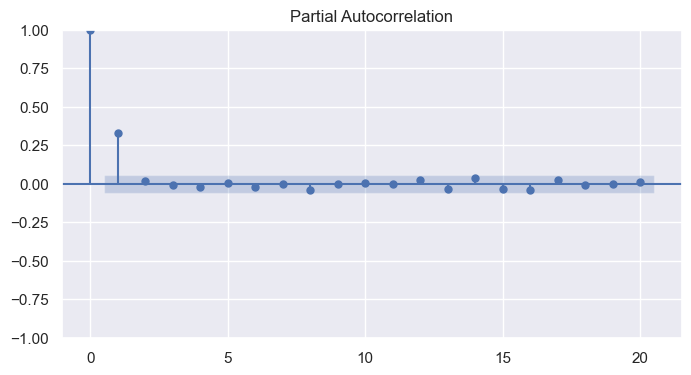

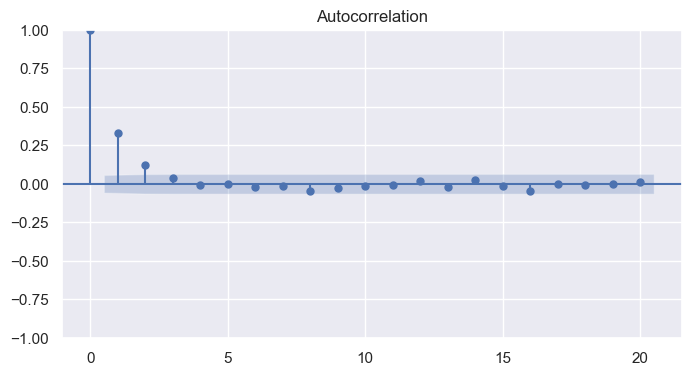

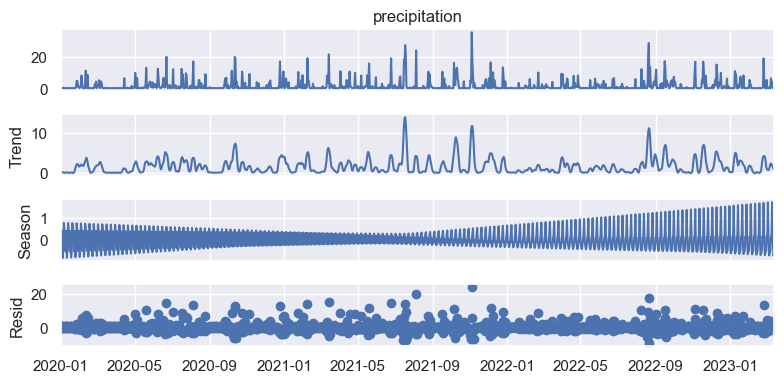

In [3]:
plot_pacf(train['precipitation'], lags=20, method='ols')
plt.show()
plot_acf(train['precipitation'], lags=20)
plt.show()

stl = STL(train['precipitation'],seasonal=365).fit()
stl.plot().show()

RMSE:  5.629259767056475
MAE:  3.246084409205045


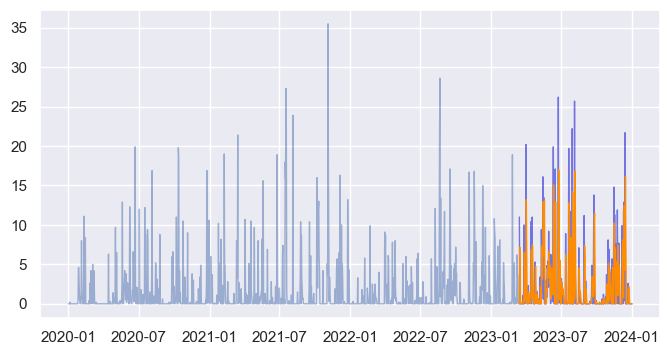

In [4]:
#TIME SERIES ARIMA MODEL
p,d,q = 1,2,1
#WALK FORWARD EVALUATION
train.index = pd.DatetimeIndex(train.index.values, freq='D')
val.index = pd.DatetimeIndex(val.index.values, freq='D')
actual = val['precipitation']
wf = walk_forward_loop(train,val,column_name='precipitation',order=(p,d,q))
print('RMSE: ', np.sqrt(mean_squared_error(actual, wf)))
print('MAE: ', mean_absolute_error(actual, wf))

#arima visualization
plt.plot(train['precipitation'], color='b', linewidth=1, alpha=0.5, label='train')
plt.plot(val['precipitation'], color='mediumblue', linewidth=1, alpha=0.5, label='val')
plt.plot(wf, color='darkorange',linewidth=1, label='ARIMA model prediction')
plt.show()

Na osnovu grafika vidi se da model solidno fituje podatke. Po narednom poređenju sa meteorološkim sajtom, prognoza verovatno nije ništa lošija od one dostupne na mobilnim uređajima. 

Novi istorijski podaci za testiranje prikupljeni su sa Weatherapi.com, ali format odgovora nije isti kao format podataka nad kojim je ARIMA model treniran. Funkcija `handle_data()` služi obradu pristiglih podatak u kojoj se kreira novi Data Frame sa korektnim oblikom. Odgovor sa API takođe pruža prognozu za dan za koji je poslat zahtev, tako da je bilo moguće uporediti predikciju implementiranog ARIMA modela sa onom koju pruža API. 


In [5]:
import requests
from dotenv import load_dotenv
import os
from datetime import date

key = os.getenv('api_key')

url = "http://api.weatherapi.com/v1/history.json"
params = {
    "key": key,
    "q": "Novi Sad", 
    "dt": date.today()
}
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
else:
    print(f"Request failed with status code {response.status_code}")

#Testing the model on newest data from the API
precip = data['forecast']['forecastday'][0]['day']['totalprecip_mm']
new_data = handle_data(data,train.columns)
wf = walk_forward_loop(train,new_data,column_name='precipitation',order=(p,d,q))

print(f'Predicted precipitation: {0 if wf[-1] < 0 else wf[-1]} mm')
print(f'Forecasted by weatherapi: {precip} mm')

Predicted precipitation: 0 mm
Forecasted by weatherapi: 0.0 mm


RMSE with XGBOOST: 3.5705318250358866
MAE 1.9459152936375996


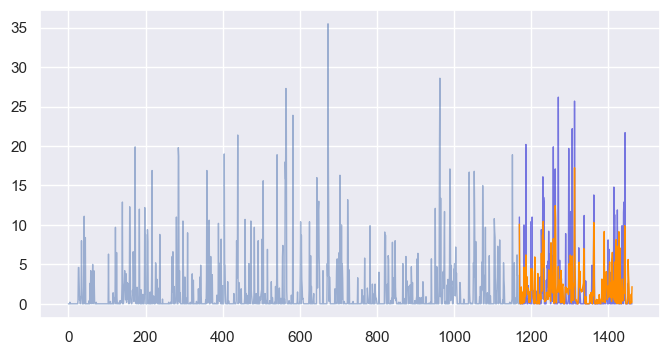

In [6]:
#GRADIENT BOOSTING FROM XGBOOST
# Find the best hyperparameters using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6]
}
model = XGBRegressor(objective='reg:squarederror',random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Fit the model with the best hyperparameters
model = XGBRegressor(objective='reg:squarederror', n_estimators=best_params['n_estimators'], 
                     learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=42)
model.fit(X_train, y_train)   
y_pred = model.predict(X_val)
y_pred = np.maximum(y_pred, 0)

#xgboost visualization
plt.plot(trainxg['precipitation'], color='b', linewidth=1, alpha=0.5, label='train')
plt.plot(valxg['precipitation'], color='mediumblue', linewidth=1, alpha=0.5, label='val')
plt.plot(range(split,split+len(valxg)),y_pred, color='darkorange',linewidth=1, label='XGBoost prediction')
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE with XGBOOST: {RMSE}')
print('MAE', mean_absolute_error(y_val, y_pred))

Kako bi se optimizovali hiperparametri modela, iskorišćen je `GridSearchCV()` koji isprobava sve vrednosti iz zadatog skupa da bi pronašao najbolje rešenje.

Poređenjem ručno implementiranog Gradient Boost algoritma i onog iz biblioteke, vidi se da najveći uticaj na razlike rezultata ima podešavanje hiperparametara poput dozvoljene maksimalne dubine do koje će se stablo odlučivanja razvijati i na koliko grana će se deliti, pored broja iteracija i brzine učenja. Razlog underfittinga najverovatnije leži u samoj prirodi podataka jer je veoma teško zaključiti kada i koliko kiše će pasti i za bolje rezultate morao bi biti mnogo veći uzorak podataka za više različitih lokacija.

RMSE with custom GradientBoost: 3.65649236099907
MAE 2.0530405189668968


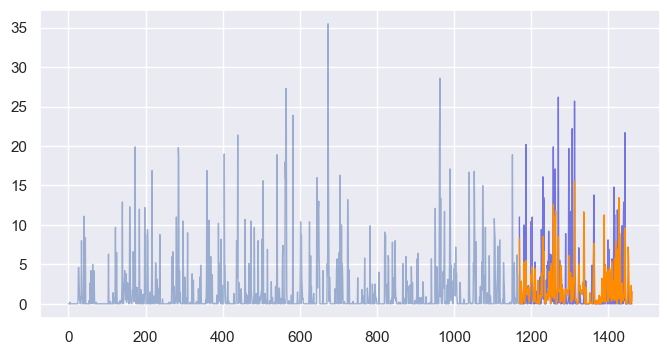

In [7]:
#GRADIENT BOOSTING
#convert into numpy arrays and scale
y_train1 = np.array(y_train).reshape(X_train.shape[0],1)
y_val1 = np.array(y_val).reshape(X_val.shape[0],1)

#custom gradient boosting model
G = GradientBooster(max_depth=best_params['max_depth'],lr=best_params['learning_rate'],iter=best_params['n_estimators'],random_state=42)
models = G.train(X_train,y_train1)
y_pred1 = G.predict(models,X_val)
y_pred1 = np.maximum(y_pred1, 0)

#visualization
plt.plot(trainxg['precipitation'], color='b', linewidth=1, alpha=0.5, label='train')
plt.plot(valxg['precipitation'], color='mediumblue', linewidth=1, alpha=0.5, label='val')
plt.plot(range(split,split+len(valxg)),y_pred1, color='darkorange',linewidth=1, label='XGBoost prediction')

rmse = np.sqrt(mean_squared_error(y_val1, y_pred1))
print(f'RMSE with custom GradientBoost: {rmse}')
print('MAE', mean_absolute_error(y_val1, y_pred1))

### Zaključak
ARIMA modeli su dizajnirani da hvataju vremenske zavisnosti u podacima vremenskih serija, dok je gradijentna metoda namenjena za modele mašinskog učenja opšte namene. ARIMA model bolje odgovara podacima čak i ako ima veći RMSE iz razloga što su podaci o samim padavinama, za razliku od generalnog vremena u toku dana, isuviše nasumični i sa kratkotrajnim zavisnostima, da bi gradijentni metod uspeo da ostvari dobre predikcije.